# Reto Deep Learning

Andrea Quiroz A01026486

Esteban Valle A01747146

## Introducción

#### Explicación del problema

### Tenemos que hacer un modelo de red convolucional para clasificar prendas usando la base de ados Fashion MNIST. Este es un problema de clasificación de clases múltiples. Debido a que tenemos las labels en el dataset y con estas vamos a hacer el entrenamiento, es un problema de supervised deep learning (aprendizaje profundo supervisado). Después de explorar la documentación del dataset encontramos que son 10 clases en total. El dataset ya viene dividido en train y test. El train set tiene 60000 entradas mientras que el test set tiene 10000. El dataset en total cuenta con 70000 instancias. Para evitar sesgos a la hora de hacer el model, dividiremos el train set en train y validation, siendo el validation 20% del total del train set. De etsa manera, nos quedan 48000 datos en el train set y 12000 en el validation set.

#### Importar librerías

In [1]:
#For data manipulation and cvisualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#For modeling
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils import model_to_dot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Desacrgar la base de datos

In [2]:
f_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = f_mnist.load_data()

#### Exploración de la base de datos

In [3]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


In [4]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Tenemos diez clases en el dataset. Después de ver la documentación, podemos ver que las etiquetas son las siguientes:


0 - T-Shirt/Top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandals

6 - Shirt

7 - Sneaker

8 - Bag

9 - Ankle boots

#### Separación del train en train y validation

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (48000, 28, 28)
y_train shape: (48000,)


In [8]:
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_val shape: (12000, 28, 28)
y_val shape: (12000,)


In [9]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [10]:
print('Valor mínimo de X_train:', X_train.min())
print('Valor máximo de X_train:', X_train.max())
print('Valor mínimo de X_val:', X_val.min())
print('Valor máximo de X_val:', X_val.max())

Valor mínimo de X_train: 0
Valor máximo de X_train: 255
Valor mínimo de X_val: 0
Valor máximo de X_val: 255


Reescalar imágenes de 0-255 a 0-1 para normalizarlas


In [11]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Data Vusialization

In [12]:
def visualize_dataset(n,x,y):
    plt.figure(figsize=(10,10))
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.get_cmap('gray'))
        plt.xlabel(y[i])
    plt.show()

/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPy

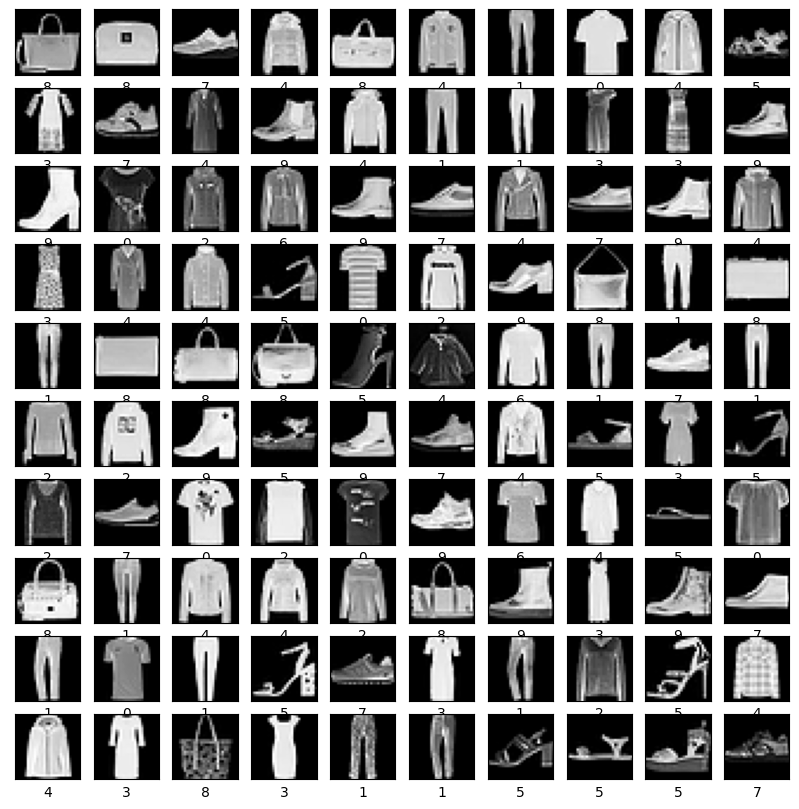

In [13]:
visualize_dataset(10, X_val, y_val)

In [14]:
def visualize_labels(y,visualize=False):
    unique, counts = np.unique(y, return_counts=True) # Encuentra los elementos únicos de un array
    print('Clases: ', unique)
    print('Número de instancias por clase', counts)

    if visualize == True:
        plt.figure(figsize=(11,5))
        plt.bar(unique,counts, color = (0.3,0.1,0.4,0.6))
        plt.xlabel('Clases')
        plt.ylabel('Frecuencia')
        plt.xticks(unique)

        for i, v in enumerate(counts):
            plt.text(i-0.25, v+10, str(v), color = 'blue')
        plt.show()


Clases:  [0 1 2 3 4 5 6 7 8 9]
Número de instancias por clase [4798 4781 4795 4816 4798 4789 4782 4841 4803 4797]


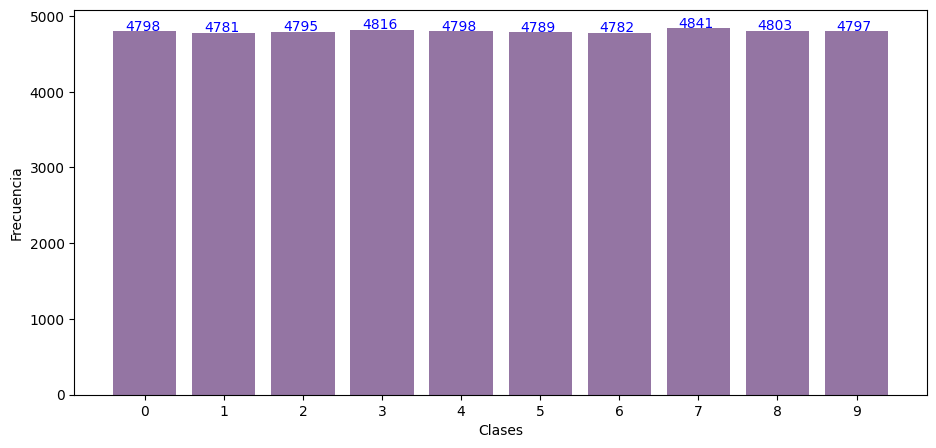

In [15]:
visualize_labels(y_train, True)

## Modelo 1

En este modelo usamos una red con varias capas. Hacemos uso de diferentes layers como Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten y Dense. En este modelo usamos un kernel de 5x5, la función de activación de las capas ocultas es 'relu', la función de salida es softmax (pues es un problema de clasificación con clases múltiples), hacemos dropout de 25% y 50% y usamos 32, 64, 128 y 256 filtros.

#### Definir

In [16]:
model12 = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28 ,28 ,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    Dense(10, activation='softmax') 
])

In [42]:
model12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          5

In [18]:
plot_model(model12, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Explicación de cada capa 

Las capas que se utilizan en este modelo son las siguientes:

- Conv2D: Esta capa convolucional se utiliza para extraer características de la imagen de entrada. La capa crea un núcleo de convolución que se convoluciona con la entrada de la capa para producir un tensor de salidas. El número de filtros dentro de la capa son los que definen la demisión de la función  final que se va a obtener
    - Los filtros son el número de mapas de activación. El objetivo es generar diferentes tipos de filtros para poder observar diferentes características de las imágenes. En este caso se utilizan diferentes valores de los filtros para cada capa, en la primera se utilizan 32 y en la segunda 64.
    - El tamaño del kernel es quien determina qué tanta información se va a extraer y de qué tamaño serán los mapas característicos. En el primer modelo se utiliza un kernel cuadrático de 5x5, este tamaño es una parámetro bastante estándar pues esto obliga al algoritmo a aprender características comunes a diferentes situaciones y así generalizar mejor. La razón por la que no se ocupa una matriz 1x1 es por que únicamente estaría extrayendo información local sin información de los píxeles vecinos.
    - Después, la función de activación tiene la función de introducir no linealidades al modelo, esto le permite a la red modelar relaciones más complejas y capturar características no lineales, pues de otra forma el modelo se reduciría a una única transformación lineal. La función de activación que se ocupa es la de ReLU, la cual únicamente otorga un valor de 0 a todos los valores negativos y mantiene los valores positivos sin cambio.
    - Por ultimo, el input shape es el que establece la forma de los datos de entrada, en este caso, se esta trabajando con un entrada de 28 x 28 pixeles y un solo canal de color. Por lo tanto, la forma es de 28, 28, 1.

- Batch Normalization: Es una capa de red que se inserta entre una capa y otra capa oculta. Su trabajo es tomar las salidas de la primera capa oculta y normalizarlas antes de pasarlas como entrada de la siguiente capa oculta. El objetivo de esta capa es reducir la cantidad de épocas de entrenamiento, pues los pesos de las dentro de la red están dentro de la misma escala. En este caso se utiliza los valores estándar que están dentro de keras, que es la media de 0 y la desviación estándar de 1. 

- Activation: Esta capa se utiliza para aplicar una función de activación a la salida de la capa anterior. En este caso, se utiliza la función ReLu dentro de todas las capas ocultas, donde es 0 para los valores negativos y mantiene los valores positivos.

- MaxPooling2D: Esta capa de agrupación se utiliza para reducir el muestreo de la entrada. Esta capa calcula el máximo valor para cada píxel de tamaño de ventana definido por el argumento pool_size, en este caso la venta es una de 2x2. El objetivo es reducir la cantidad de parámetros entrenables para reducir el overfitting. Al conservar los valores más altos, esto blinda a la red de pequeñas distorsiones.

- Dropout: Esta capa se utiliza para desactivar aleatoriamente un porcentaje de neuronas de la capa anterior en cada paso de entrenamiento, lo que ayuda a evitar el overfitting. Los porcentajes del dropout dentro del modelo varían entre 0.25 y 0.5

- Flatten: el objetivo del método Flatten es apalancar los datos de salida tras las capas convolucionales o de pooling. La razón por la que se aplica este proceso es debido a que tras las redes convolucionales que están procesando imágenes, el resultado es un vector tridimensional, por lo tanto es importante convertirlo en un vector unidimensional antes de meterlo a las capas densas.

- Capas ocultas: Dentro del modelo se utilizan cuatro capas densas dentro de las capas ocultas. Las capas densas son capas en la que cada neurona está  conectada con todos los nodos de la capa anterior. En este caso, las capas varían entre 128 y 256 neuronas por cada capa. Así mismo, todas las capas ocultas utilizan la función de activación ReLU.

- Capa de salida: Por último, dentro de la capa de salida se utiliza una capa densa de 10 neuronas. La razón por la cual se ocupa este número de neuronas es por que debe ser igual al número de clases que debes clasificar. Al ser una problema de multi clase se utiliza la función softmax, la cual es una generalización de la función sigmoide. Tras esta capa, obtener un array con las probabilidad que tendría cada clase.


### Cálculo de parámetros

El cálculo de los parámetros entrenables se hace de la sigueinte manera:

#### <u>Conv2D</u>

Output shape de la capa Conv2D: (None, $W_{out}$, $H_{out}$, # filters)
* $\mathbf{W_{out} = \frac{W_{in} - K + 2P}{S} + 1}$
* $\mathbf{H_{out} = \frac{H_{in} - K + 2P}{S} + 1}$

Donde 

$W_{in} \times H_{in}$ es la dimensión de una imagen

$K \times K$ son las dimensiones del filtro

$P$ es el padding 

$S$ es el stride

Sálida de parámetros capa Conv2D: 

* $\mathbf{Conv2D\_param = [(K \times K \times F_p) + 1] \times F}$

Dónde:

$K x K$ es el tamaño del kernel

$F_p$ es el # de filtros previos

$F$ es el # de filtros en esta capa

#### <u>BatchNormalization</u>

Sálida de parámetros de BatchNormalization

* $\mathbf{BatchNormalization\_param = 4 \times F_p}$

Dónde:

$F_p$ es el # de filtros previos

#### <u>MaxPooling2D</u>

Output de la capa de MaxPooling2D: (None, $MaxPooling$, $MaxPooling$, # filters de la capa conv2d previa)

* $\mathbf{ MaxPooling = \frac{Input - K}{S}+1}$

Donde 

$K$ es el tamaño del filter/kernel

$S$ es el # del strides.


#### <u>Flatten</u>

Output de la capa de Flatten: (None, Flatten)

* $\mathbf{ Flatten = W_{p} \times H_{p} \times F_{p}}$

Donde 

$W_{p} \times H_{p}$ es la dimensión de la capa anterior

$F_p$ es el # de filtros previos

#### <u>Dense</u>

Output de la capa de Dense: (None, Dense)

* $\mathbf{Dense = I_{p} \times I + I}$

Donde 

$I_{p}$ es el input de la capa anterior

$I$ es el input de esta capa

Por ejemplo, aplicando estas fórmulas podemos calcular los parámetros de las primeras capas.

#### <u>Conv2D</u>

Output shape de la capa Conv2D: ($None$, $24$, $24$, $32$)

* $\mathbf{W_{out} = \frac{W_{in} - K + 2P}{S} + 1 = \frac{28 - 5 + 2(0)}{1} + 1 = 24}$
* $\mathbf{H_{out} = \frac{H_{in} - K + 2P}{S} + 1 = \frac{28 - 5 + 2(0)}{1} + 1 = 24}$

Sálida de parámetros capa Conv2D: 

* $\mathbf{Conv2D_param = [(K \times K \times F_p) + 1] \times F = [(5 \times 5 \times 1) + 1] \times 32 = 832}$

#### <u>BatchNormalization</u>

Sálida de parámetros capa BatchNormalization: 

* $\mathbf{BatchNormalization\_param = 4 \times F_p = 4 \times 32 = 128}$

#### <u>MaxPooling2D</u>

Output shape de la capa MaxPooling2D: (None, 12, 12, 32)

* $\mathbf{ MaxPooling = \frac{Input - K}{S}+1 = \frac{24 - 2}{2}+1 = 12}$

#### <u>Flatten</u>

Output de la capa de Flatten: (None, Flatten)

* $\mathbf{ Flatten = W_{p} \times H_{p} \times F_{p} = 4 \times 4 \times 64 = 1024}$


#### <u>Dense</u>

Output de la capa de Dense: (None, Dense)

* $\mathbf{Dense = I_{p} \times I + I = 128 \times 64 + 64 = 8256}$

#### Compilar

In [19]:
model12.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Entrenar/Ajustar

In [20]:
history112 = model12.fit(X_train, y_train,
                  batch_size=128,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/20


375/375 [==============================] - 12s 30ms/step - loss: 1.1535 - accuracy: 0.6173 - val_loss: 2.3816 - val_accuracy: 0.1016
Epoch 2/20
375/375 [==============================] - 10s 28ms/step - loss: 0.5908 - accuracy: 0.7894 - val_loss: 0.4928 - val_accuracy: 0.8191
Epoch 3/20
375/375 [==============================] - 11s 29ms/step - loss: 0.4870 - accuracy: 0.8298 - val_loss: 0.3776 - val_accuracy: 0.8586
Epoch 4/20
375/375 [==============================] - 11s 28ms/step - loss: 0.4303 - accuracy: 0.8479 - val_loss: 0.3801 - val_accuracy: 0.8554
Epoch 5/20
375/375 [==============================] - 11s 28ms/step - loss: 0.4023 - accuracy: 0.8585 - val_loss: 0.3636 - val_accuracy: 0.8640
Epoch 6/20
375/375 [==============================] - 11s 29ms/step - loss: 0.3783 - accuracy: 0.8645 - val_loss: 0.3619 - val_accuracy: 0.8627
Epoch 7/20
375/375 [==============================] - 10s 27ms/step - loss: 0.3583 - accuracy: 0.8739 - val_loss: 0.2939 - val_accuracy: 0.8922
Epo

### Gráficas

#### Loss & Accuracy

/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPy

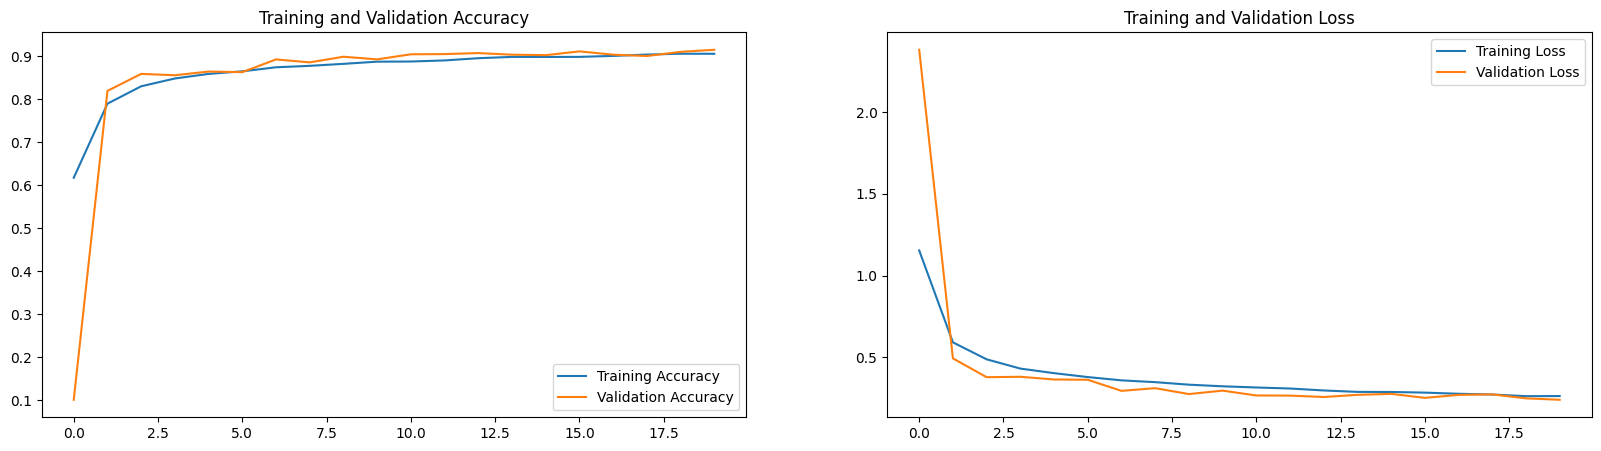

In [21]:
# Visualizar gráficas de aprendizaje
acc1 = history112.history['accuracy']
val_acc1 = history112.history['val_accuracy']

loss1 = history112.history['loss']
val_loss1 = history112.history['val_loss']

epochs_range = np.arange(len(history112.history['loss']))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Accuracy')
plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

***********************************************************************************************

## Modelo 2

En este modelo usamos una red con pocas capas. Hacemos uso de diferentes layers como Conv2D, MaxPooling2D, Dropout, Flatten y Dense. En este modelo usamos un kernel de 3x3, la función de activación de las capas ocultas es 'relu', la función de salida es softmax (pues es un problema de clasificación con clases múltiples), hacemos dropout de 25%, 30% y 40% y usamos 32, 64 y 128 filtros.

#### Definir

In [22]:
model2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

In [23]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)         

In [24]:
plot_model(model12, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Explicación de cada capa 

- Conv2D: En este modelo ocupamos tres capas convolucionales, de 32, 64 y 128 filtros respectivamente. El tamaño de los kernel varían entre matriz cuadrática de 3x3 y 2x2. Así mismo, utilizan la función de activación ReLU. 
    - Kernel inicializer: Este método se utiliza para inicializar los pesos de los filtros que se aplican durante la convolución. Los pesos son los parámetros que la red neuronal aprende durante el entrenamiento. La estrategia que se utiliza en este modelo es la de “he_uniform”, la cual inicializa los pesos utilizando la distribución He, ajustada para funciones de activación con ReLU. 

- Max Pooling: Dentro de este módulo se utiliza el método de max polling tras las primeras dos capas convolucionales. Cada una de estas ocupa una matriz de 2x2.

- DropOut: Tras cada capa convolucional y cada capa oculta, se utiliza un dropout que elimina aleatoriamente un porcentaje de las neuronas. El porcentaje del dropout varía entre 0.25, 0.4 y 0.3 respectivamente, El mayor porcentaje se aplica en la última red convolucional debido a que a esa capa no se le hace ningún proceso de pooling.

- Flatten: Después de todas las capas convolucionales y del max pooling, se hace un proceso de aplanamiento que reduce la dimensionalidad de los datos de un vector tridimensional a uno unidimensional.


#### Compilar

In [25]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Entrenar/Ajustar

In [26]:
history2 = model2.fit(X_train, y_train,
                  batch_size=128,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/20


375/375 [==============================] - 9s 24ms/step - loss: 0.7321 - accuracy: 0.7250 - val_loss: 0.4569 - val_accuracy: 0.8300
Epoch 2/20
375/375 [==============================] - 9s 23ms/step - loss: 0.4668 - accuracy: 0.8270 - val_loss: 0.3649 - val_accuracy: 0.8656
Epoch 3/20
375/375 [==============================] - 9s 24ms/step - loss: 0.3966 - accuracy: 0.8551 - val_loss: 0.3209 - val_accuracy: 0.8794
Epoch 4/20
375/375 [==============================] - 9s 24ms/step - loss: 0.3608 - accuracy: 0.8670 - val_loss: 0.3060 - val_accuracy: 0.8826
Epoch 5/20
375/375 [==============================] - 9s 23ms/step - loss: 0.3326 - accuracy: 0.8766 - val_loss: 0.2913 - val_accuracy: 0.8939
Epoch 6/20
375/375 [==============================] - 9s 25ms/step - loss: 0.3195 - accuracy: 0.8826 - val_loss: 0.2765 - val_accuracy: 0.8970
Epoch 7/20
375/375 [==============================] - 9s 24ms/step - loss: 0.3028 - accuracy: 0.8900 - val_loss: 0.2702 - val_accuracy: 0.9013
Epoch 8/20

### Gráficas

#### Loss & Accuracy

/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPy

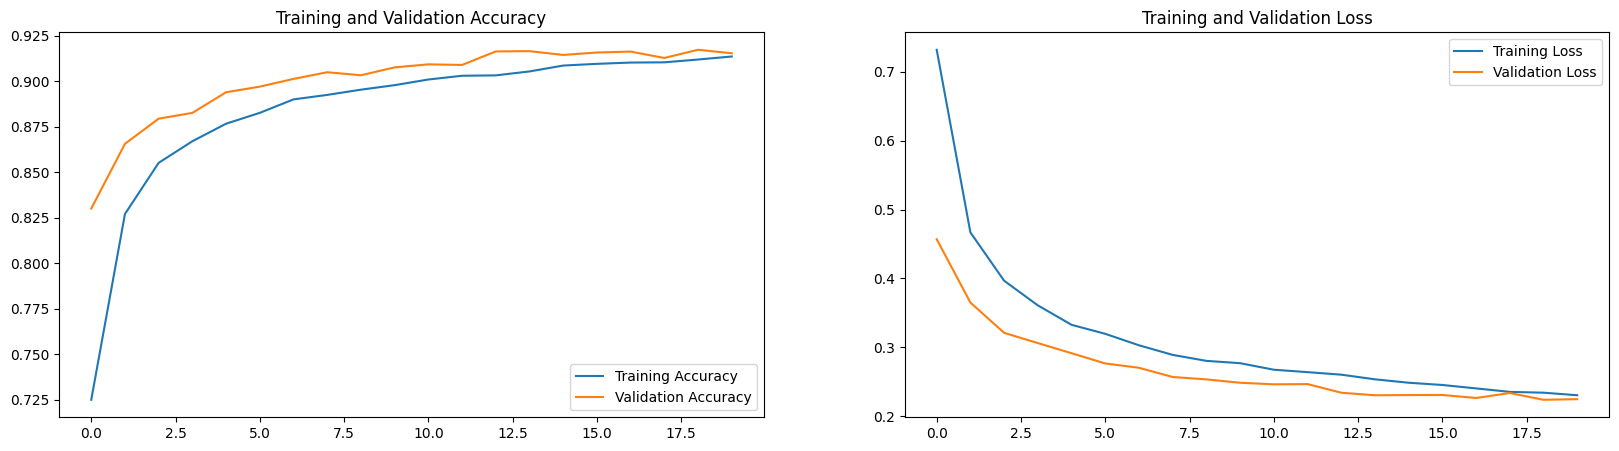

In [27]:
# Visualizar gráficas de aprendizaje
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = np.arange(len(history2.history['loss']))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

## Comparación

In [28]:
print('*** Modelo 1 ***')
print(f'Train accuracy: {acc1[-1]:.2f}')
print(f'Validation accuracy: {val_acc1[-1]:.2f}')
print(f'Train loss: {loss1[-1]:.2f}')
print(f'Validation loss: {val_loss1[-1]:.2f}')
print()
print('*** Modelo 2 ***')
print(f'Train accuracy: {acc2[-1]:.2f}')
print(f'Validation accuracy: {val_acc2[-1]:.2f}')
print(f'Train loss: {loss2[-1]:.2f}')
print(f'Validation loss: {val_loss2[-1]:.2f}')

*** Modelo 1 ***
Train accuracy: 0.91
Validation accuracy: 0.91
Train loss: 0.26
Validation loss: 0.24

*** Modelo 2 ***
Train accuracy: 0.91
Validation accuracy: 0.92
Train loss: 0.23
Validation loss: 0.22


Extisten varias diferencias entre el modelo 1 y el modelo 2. Para empezar, la arquitectura de los modelos son diferentes, pues utilizan distintas capas ocultas y en cantidades variadas. En el primer modelo usamos BatchNormalization y Activation, mientras que en el segundo modelo no los usamos. Además, en el modelo 1 usamos un kernel de 5x5, y en el modelo 2 usamos un kernel de 3x3. En cuanto a similitudes entre los modelos, ambos los compilamos con el mismo optimizer, funciton loss, número de batch size y número de epochs.

Profundizando en qué representa la diferencia en las arquitecturas de los modelos, el primer modelo utiliza mayor cantidad de capas mientras que el segundo modelo contiene muy pocas capas. En el primer modelo se utilizan cuatro capas densamente conectadas, donde sólo en dos de estas cuatro capas se aplica un dropout. En comparación, el segundo modelo sólo se utiliza una capa densamente conectada y en esta misma se utiliza un dropout. Esto puede explicar por qué existe un mayor overfitting dentro del primer modelo. En síntesis, el modelo 1 tiene mayor información interconectada que el modelo 2, esto puede hacer que los procesos de generalización lleguen a ser más efectivos dentro del segundo modelo, pues no tienden a generar procesos tan especificos que solo son aplicables para los datos de entrenamiento.

Como podemos ver en los resultados y gráficas de accuracy y loss de cada modelo, ambos modelos tienen un buen puntaje de accuracy tanto en el train data como en el validation. Esta simulitud en accuracy en train y validation nos indica que el modelo es bueno generalizando. Sin embargo, podemos observar que el modelo 2 tiene mejor rendimiento que el modelo 1 por doz razones. Uno, el modelo 2 tiene mejor accuracy en el validation data que el modelo 1. Dos, el modelo 2 tiene menor pérdida tanto en el train data como el validation que le modelo 1. Por esta razón, decidimos seleccionar el modelo 2 y evaluarlo con nuestro test data.

## Evaluación

Con el modelo 2, el cual cosnideramos es el mejor de los dos realizados, vamos a usar el conjunto de test  y mostrar el desempeño real de nuestra red convolucional.

In [29]:
test_loss, test_acc = model2.evaluate(X_test, y_test , verbose=0)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

Test accuracy: 0.92
Test loss: 0.24


## Predicción

In [30]:
y_pred = model2.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [31]:
print(y_pred[1])

[6.30704790e-06 5.50280394e-12 9.99884367e-01 2.18707726e-07
 4.40219765e-06 1.54427976e-15 1.04623010e-04 3.40653226e-16
 1.11466445e-08 1.54812025e-14]


In [32]:
# Suma de las salidas de softmax
print(np.sum(y_pred[1]))

0.99999994


In [33]:
y_pred = np.argmax(model2.predict(X_test), axis=-1)
y_pred

 45/313 [===>..........................] - ETA: 0s

313/313 [==============================] - 1s 3ms/step


array([9, 2, 1, ..., 8, 1, 5])

In [34]:
print(y_pred[1])

2


/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPy

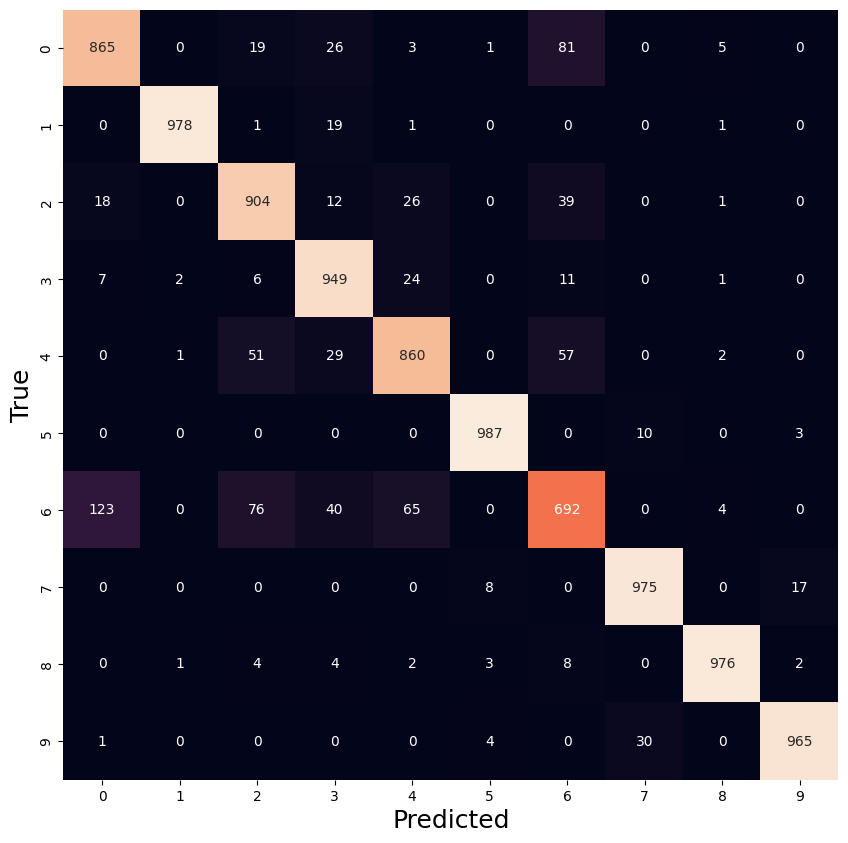

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True,cbar=False,fmt='d')
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel("True", fontsize = 18)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.85      0.90      0.88      1000
           3       0.88      0.95      0.91      1000
           4       0.88      0.86      0.87      1000
           5       0.98      0.99      0.99      1000
           6       0.78      0.69      0.73      1000
           7       0.96      0.97      0.97      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.91      0.92      0.91     10000
weighted avg       0.91      0.92      0.91     10000



In [37]:
def plot_prediction(index):
    print('Valor real: ',y_test[index])
    print('Predicción: ',y_pred[index])
    plt.figure(figsize=(6,3))
    plt.imshow(X_test[index], cmap='gray')
    plt.axis('off')
    plt.show()


Valor real:  4
Predicción:  4


/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andreaquiroz/Library/Python/3.11/lib/python/site-packages/IPy

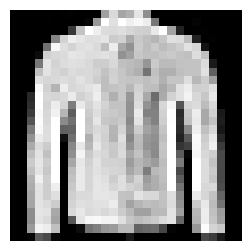

In [38]:
i = 50
plot_prediction(i)

Valor real:  3
Predicción:  3


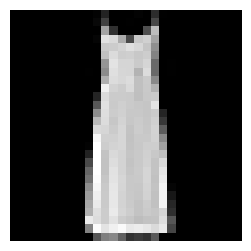

In [39]:
i = 13
plot_prediction(i)

Valor real:  6
Predicción:  4


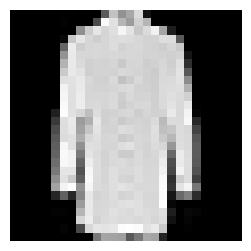

In [40]:
i = 444
plot_prediction(i)

Valor real:  1
Predicción:  1


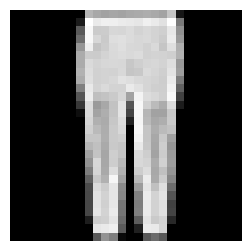

In [41]:
i = 3000
plot_prediction(i)

## Conclusiones

### Andrea

##### Posibles mejoras

En el modelo 1 hay un poco de overfitting. Esto podríamos evitarlo reduciendo el número de epocas. En el segundo modelo, tiene buen ajuste, pues este llega a un punto de estabilidad y hay una brecha prqueña entre el loss y accuracy de train y validation. A este modelo no le cambiaría nada en concreto, pues tuvo un buen puntaje de accuracy y rendimiento en el conjunto de test. Sin embargo, hay cosas que podemos modificar para y probar si el desempeño del modelo mejora. Algunos cambios que podíamos hacer para ver mejoras es hacer data augmentation al dataset con el fin de mejorar su clasificación entre prendas similares, como t-shirt y coat. Otra mejora que podemos hacer es hacer más modelos y comparar entre estos. Los resultados obtenidos en este proyecto son producto de la comparación de dos modelos. Si tuvieramos más modelos, pdoríamos encontrar uno todavía mejor. Por útlimo, una posibilidad para mejorar el resultado es usar redes que ya han sido investigadas e identificadas como buenas para hacer clasificación de imágenes multiclase en donde hay clases que son similares. Un ejemplo puede ser usar ResNet-18 o VGG16.

##### Actividades realizadas

Las actividades que realicé para este proyecto fue el diseño y arquitctura del primer modelo. Hice varias pruebas e intente diferentes arquitecturas hasta que encontré una que tenía un buen nivel de accuracy (=> 90) y el mínimo valor de loss. Igual ciudé que no hubiera overfitting usando las gráficas de loss y accuracy tanto para train como validation. En cuanto a la parte de investigación, mi aportación fue en como realizr los cálculos para los parámetros entrenables. En conjunto, mi compañero y yo hicimos la comparación de los modelos y determinamos cual era el mejor. 

### Esteban

##### Posibles mejoras

Dentro del primer modelo creo que se podría reducir el overfitting agregando un dropuot por cada cada. O en su defecto creo que se podría reducir el número de capas que se ocultas y convolucionales que se tiene dentro de la arquitectura. Dentro del segundo modelo, creo que un área de mejora que tenía el modelo es el implementar data augmentation, la cual fue una técnica que logramos implementar pero al momento de mezclar los códigos tuvimos que borrar, pero considero que eso habría sido una mejor oportunidad al momento de entrenar el modelo.

##### Actividades realizadas

Por su parte , yo fui el encargado de realizar la segunda propuesta de modelo. Para esto investigue trabajos anteriores que se hicieron con la base datos y compare los diferentes modelos junto con el diferente tratamiento que le daban a los datos. Al final, junto con mi compañera juntamos los códigos para poder comparar los resultados de ambos modelos.

## Referencias

Dataset:

Han Xiao, Kashif Rasul, & Roland Vollgraf (2017). Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. CoRR, abs/1708.07747. Retrieved from: http://arxiv.org/abs/1708.07747

 

Data Augmentation Reference:

Foucardm. (2020, 9 agosto). Data augmentation on the MNIST dataset. Kaggle. https://www.kaggle.com/code/foucardm/data-augmentation-on-the-mnist-dataset/notebook

 

CNN con Tensorflow de la profesora Andrea Torres:

https://colab.research.google.com/drive/1sWhP2AnjsvEdD1mLbusXEeb2sD4H1mzu#scrollTo=HGvyJbZ8Y6jA